In [43]:
 # import libraries
import uhd
from uhd import libpyuhd as lib
import numpy as np
import threading
import time
import scipy.io
from scipy.signal import chirp, spectrogram

# import the gain tables
import matplotlib.pyplot as plt
from scipy.io import loadmat
# These delays are used to align the buffers, used later in code
INIT_DELAY = 0.018
##TX_DELAY   = 0.012
TX_DELAY   = 0.010
# setup general parameters, see documentation for detailed explanation of params




In [31]:
# from radar_parameters2 import * # import the parameters used in the radar

# define radar parameters
##start_freq = 800e6
##freq_step  = 16e6
##end_freq   = 4e9
start_freq = 2200e6
freq_step  = 16e6
end_freq   = start_freq + freq_step *4


# device parameters
samp_rate = 16e6
master_clock_rate = 16e6
# the second tx gain was used, but not needed if using gain tables
tx_gain = 80
tx_gain2 = 85
rx_gaina = 20
rx_gainb = 20
rx_gain = 20

In [32]:
#from gain_parameters import *
import scipy.io
# Load data and save
#gain_a = scipy.io.loadmat('gain_a.mat')
#gain_b = scipy.io.loadmat('gain_b.mat')
#gain_a= gain_a['gain_a']
#gain_b = gain_b['gain_b']

gain_a = 80
gain_b = 80

# repeat for channel B
#gainhw_a = scipy.io.loadmat('gainhw_a.mat')
#gainhw_b = scipy.io.loadmat('gainhw_b.mat')
#gainhw_a = gainhw_a['gainhw_a']
#gainhw_b = gainhw_b['gainhw_b']
gainhw_a = 80
gainhw_b = 80

In [33]:
def setup_device(samp_rate, master_clock_rate, tx_gain, rx_gain):
    """
    set up everything except center frequency
    :return: a MultiUSRP device object, a tx_streamer, a rx_streamer
    """
    # define device parameters for daughter board and clock of the system
    args = "type = b200"
    subdevice = "A:A" # select subdevice in the daughterboard
    freq_clock_source = "internal"
    rx_band_width = samp_rate
    tx_band_width = samp_rate
    channel_list = [0] ##channel_list = [0, 1]
    
    # create a usrp device and set up it with the device parameters defined above
    usrp = uhd.usrp.MultiUSRP(args)
    
    # set clock ant time
    # this sets the source of the frequency reference, typically a 10 MHz signal
    usrp.set_clock_source(freq_clock_source) 
    
    usrp.set_master_clock_rate(master_clock_rate)
    
    # select subdevice
    subdevice_spec = lib.usrp.subdev_spec(subdevice)
    usrp.set_rx_subdev_spec(subdevice_spec)
    usrp.set_tx_subdev_spec(subdevice_spec)
    print("Using Device: {}".format(usrp.get_pp_string()))
    
    # set sample rate of ADC/DAC
    usrp.set_tx_rate(samp_rate) # this will set over all channels
    usrp.set_rx_rate(samp_rate)
    print("Actual RX0 rate: {} Msps".format(usrp.get_rx_rate(0) / 1e6))
    ##print("Actual RX1 rate: {} Msps".format(usrp.get_rx_rate(1) / 1e6))
    print("Actual TX0 rate: {} Msps".format(usrp.get_tx_rate(0) / 1e6))
    ##print("Actual TX1 rate: {} Msps".format(usrp.get_tx_rate(1) / 1e6))
    
    # set bandwidth
    usrp.set_tx_bandwidth(tx_band_width, channel_list[0])

    
    usrp.set_rx_bandwidth(rx_band_width, channel_list[0])

    
    print("Actual RX0 bandwidth = {} MHz".format(usrp.get_rx_bandwidth(0)/ 1e6))

    
    print("Actual TX0 bandwidth = {} MHz".format(usrp.get_tx_bandwidth(0)/ 1e6))

    
    # create stream args and tx streamer
    st_args = lib.usrp.stream_args("fc32", "sc16")
    st_args.channels = channel_list
    
    # create tx streamer
    tx_streamer = usrp.get_tx_stream(st_args)
    
    # create rx streamer
    rx_streamer = usrp.get_rx_stream(st_args)
    
    return usrp, tx_streamer, rx_streamer




In [34]:
def init_usrp_device_time(usrp):
    """
    set the usrp device time to zero
    :param usrp: a MultiUSRP Device
    """
    usrp.set_time_now(lib.types.time_spec(0.0))
    return


In [35]:
# define tx worker: the tx worker should always
#send data until all the freq data are saved

def tx_worker(tx_streamer, tx_data, tx_md):
    
    total_num_samps = 2000 # this defines the number of samples to send
    num_acc_samps   = 0
    num_tx_samps    = 0
    # define timing specifications
    tx_md.time_spec = uhd.types.TimeSpec(usrp.get_time_now().get_real_secs() + TX_DELAY)
    while num_acc_samps < total_num_samps:
        num_tx_samps += tx_streamer.send(tx_data, tx_md) * num_channels
        
        num_acc_samps += min(total_num_samps - num_acc_samps,tx_streamer.get_max_num_samps())
    
# print(num_tx_samps)
# the tune_center_freq represents the tx/rx tune state



In [36]:
def tune_center_freq(usrp, target_center_freq):
    global state
    ##channel_list = [0, 1]
    channel_list = [0]
    # tune center freqs on all channels
    usrp.set_rx_freq(lib.types.tune_request(target_center_freq),    0)
    ##usrp.set_rx_freq(lib.types.tune_request(target_center_freq),    1)
    usrp.set_tx_freq(lib.types.tune_request(target_center_freq),    0)
    ##usrp.set_tx_freq(lib.types.tune_request(target_center_freq),    1)
    if current_freq < 2.6e9 :
        usrp.set_tx_gain(tx_gain  , channel_list[0])
        usrp.set_rx_gain(rx_gaina , channel_list[0])
        ##usrp.set_rx_gain(rx_gaina+gain_a[0,gain_index], channel_list[0])
        ##usrp.set_rx_gain(rx_gainb+gain_b[0,gain_index], channel_list[1])
    elif current_freq >= 2.6e9:
        usrp.set_tx_gain(tx_gain2, channel_list[0])
        usrp.set_rx_gain(rx_gaina, channel_list[0])
        ##usrp.set_rx_gain(rx_gaina+gain_a[0,gain_index],channel_list[0])
        ##usrp.set_rx_gain(rx_gainb+gain_b[0,gain_index],channel_list[1])


    # wait until the lo's are locked
    while not (usrp.get_rx_sensor("lo_locked", 0).to_bool()
    and usrp.get_tx_sensor("lo_locked", 0).to_bool()):
        pass
    state = "rx_and_save_data"
    return



In [37]:
def rx_and_save_data(usrp, rx_streamer, rx_buffer, rx_md, num_rx_samps, current_freq):
    global state
    
    if current_freq > end_freq:
        state = "Done"
        return

    stream_cmd = lib.types.stream_cmd(lib.types.stream_mode.num_done)
    stream_cmd.num_samps = num_rx_samps # receive 10 periods
    stream_cmd.stream_now = False
    stream_cmd.time_spec = usrp.get_time_now() + lib.types.time_spec(INIT_DELAY)
    rx_streamer.issue_stream_cmd(stream_cmd) # tells all channels to stream
    rx = rx_streamer.recv(rx_buffer, rx_md)
    print(rx)
    # print "Current freq = {}".format(current_freq)
    state = "tune_center_freq"
    # utility function: prepare tx data
    


In [38]:
def generate_tx_data(samp_rate):
    ##channel_list = (0, 1)
    channel_list = [0]
    # generate chirp params
    fs = samp_rate
    
    # this is length of chirp
    N2 = 85000
    
    bw = 8e6
    # bandwidth of the chirp
    n = np.arange(0,N2-1)-N2/2
    t = n/fs
    
    send_chirp = np.array(np.exp(1j*np.pi*.5*(bw/t[-1])*(t**2)), dtype = np.complex64)
    
    N = 4096
    send_chirp = np.pad(send_chirp, (N), 'constant', constant_values=(0))
    wave_ampl = .8
    
    # since we have two channels to transmit, we tile tx_data
    ##tx_data = np.tile(send_chirp, (1, 1)) # also tiles to send just one period

    ##tx_data = np.tile(tx_data[0], (len(channel_list),1))
    tx_data = np.tile(send_chirp, (len(channel_list),1))
    
    
    # 2 is the length of channel
    # create tx metadata
    tx_md = lib.types.tx_metadata()
    tx_md.start_of_burst = True
    tx_md.end_of_burst   = False
    tx_md.has_time_spec  = True
    length_wave_one_period = send_chirp.size
    chirp_duration = length_wave_one_period * samp_rate
    return tx_data, tx_md, send_chirp, length_wave_one_period, chirp_duration


In [41]:
start_state = "tune_center_freq"
# state has 3 values: tune_center_freq, rx_and_save_data, Done
state = start_state # initialize state to start_state


# set up a usrp device object and get usrp, tx_streamer, rx_streamer
usrp, tx_streamer, rx_streamer = setup_device(samp_rate, master_clock_rate, tx_gain, rx_gain)
# prepare rx_buffer_list and rx metadata
# the rx_buffer_list is preallocated

##
### 
tx_data, tx_md, send_chirp, length_wave_one_period, chirp_duration = generate_tx_data(samp_rate)
###
num_rx_samps = length_wave_one_period *10
rx_md = lib.types.rx_metadata()

# create the receive buffers and freq step
num_freqs = (end_freq - start_freq) / float(freq_step) + 1
rx_buffer_list = []
rx_buffer_idx  = 0

for _ in range(int(num_freqs)):
    rx_buffer = np.zeros((1, num_rx_samps), dtype=np.complex64)
    rx_buffer_list.append(rx_buffer)

# start the tx work and set up basics for B210
init_usrp_device_time(usrp) # set device time to 0
num_channels         = tx_streamer.get_num_channels()
max_samps_per_packet = tx_streamer.get_max_num_samps()
current_freq         = start_freq
gain_index           = 0
# create the tx and rx workers before running
####t1_tx_worker = threading.Thread(target=tx_worker, args=(tx_streamer, tx_data, tx_md))

###
####r1_rx_worker = threading.Thread(target= rx_and_save_data,args=(usrp, rx_streamer, rx_buffer, rx_md, num_rx_samps, current_freq))
###
# begin the loop
start = time.time()
while True:
    if  state == "tune_center_freq":
        tune_center_freq(usrp, current_freq)
        current_freq = current_freq + freq_step
        gain_index   = gain_index + 1
    elif state == "rx_and_save_data":
        # create the tx and rx workers before running
        t1_tx_worker = threading.Thread(target=tx_worker, args=(tx_streamer, tx_data, tx_md))

        ###
        r1_rx_worker = threading.Thread(target= rx_and_save_data,
                                        args=(usrp, rx_streamer, rx_buffer_list[rx_buffer_idx], rx_md, num_rx_samps, current_freq))

        # this is the state to call both workers and save the data in the rx buffer
        r1_rx_worker.start()
        t1_tx_worker.start()
        r1_rx_worker.join()
        t1_tx_worker.join()
        rx_buffer_idx = rx_buffer_idx + 1
        
    elif state == "Done":
        break
        
end = time.time()
print("total scan time = {} seconds".format(end - start))


Using Device: Single USRP:
  Device: B-Series Device
  Mboard 0: B205mini
  RX Channel: 0
    RX DSP: 0
    RX Dboard: A
    RX Subdev: FE-RX1
  TX Channel: 0
    TX DSP: 0
    TX Dboard: A
    TX Subdev: FE-TX1

Actual RX0 rate: 16.0 Msps
Actual TX0 rate: 16.0 Msps
Actual RX0 bandwidth = 56.0 MHz
Actual TX0 bandwidth = 56.0 MHz
931910
97920
0
58249
total scan time = 0.27054738998413086 seconds


(5, 1, 931910)


/home/aalmela/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


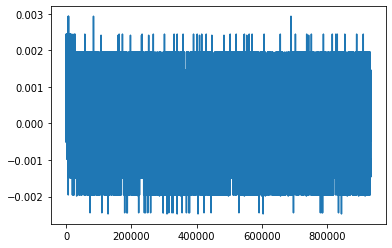

/home/aalmela/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


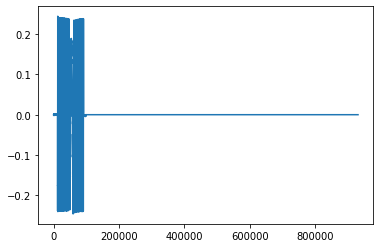

/home/aalmela/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


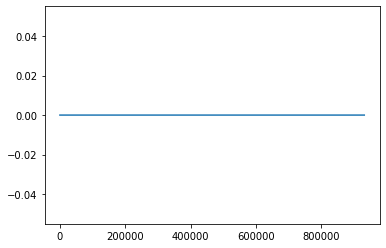

In [42]:
# save all data to a file
rx_buffer_list = np.array(rx_buffer_list)
#scipy.io.savemat("./Final/inside/loop2.mat", {"loop2": rx_buffer_list})
print(rx_buffer_list.shape)
e0  = rx_buffer_list[0,0,:]
e1  = rx_buffer_list[1,0,:]
e2  = rx_buffer_list[2,0,:]
e3  = rx_buffer_list[3,0,:]






plt.figure(1)
#plt.plot(a1[:])

#plt.plot(b1[:])
#plt.plot(d1[:])
#plt.plot(d0[:])

plt.plot(e0[:])
plt.show()

plt.figure(2)

plt.plot(e1[:])
plt.show()

plt.figure(3)
plt.plot(e2[:])
plt.show()

